# Vanilla model

In [6]:
#!/usr/bin/env python
# coding: utf-8
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters

## Load data

In [16]:
data_list = []
target_list = []

import glob
for fp in glob.glob("../hackathon_data_scripts/data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    
    data_list.append(data)
    target_list.append(targets)
#print(data_list)

# Note:
# Choose your own training and val set based on data_list and target_list
# Here using the last partition as val set

X_train = np.concatenate(data_list[ :-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_val = np.concatenate(data_list[-1: ])
y_val = np.concatenate(target_list[-1: ])
nsamples, nx, ny = X_val.shape
print("val set shape:", nsamples,nx,ny)

p_neg = len(y_train[y_train == 1])/len(y_train)*100
print("Percent positive samples in train:", p_neg)

p_pos = len(y_val[y_val == 1])/len(y_val)*100
print("Percent positive samples in val:", p_pos)

# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device (CPU/GPU):", device)
#device = torch.device("cpu")

Training set shape: 4180 420 54
val set shape: 1526 420 54
Percent positive samples in train: 25.0
Percent positive samples in val: 24.901703800786372

NOTE:
Setting batch-size to 64
Using device (CPU/GPU): cpu


## Define network

In [17]:
# Hyperparameters
input_size = 420
num_classes = 1
learning_rate = 0.01

class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()   
        self.bn0 = nn.BatchNorm1d(54)
        self.conv1 = nn.Conv1d(in_channels=54, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(100)
        
#         self.fc1 = nn.Linear(2600, num_classes)
#         torch.nn.init.xavier_uniform_(self.fc1.weight)
        
        ######## code from master thesis
        self.rnn = nn.LSTM(input_size=100,hidden_size=26,num_layers=3, dropout=0.1, batch_first=True, bidirectional = True)
        self.drop = nn.Dropout(p = 0.1)
        self.fc1 = nn.Linear(26*2, num_classes)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.softmax = nn.Softmax(dim=1)
        ########
        

    def forward(self, x):
#         x = self.bn0(x)
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.conv1_bn(x)
        
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.conv2_bn(x)
        
#         x = x.view(x.size(0), -1)
#         x = torch.sigmoid(self.fc1(x))
        
        ######## code from master thesis
        x = self.bn0(x)  
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = self.drop(x)
        x = x.transpose_(2, 1)
        x, (h, c) = self.rnn(x)
        cat = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
        cat = self.drop(cat)
        x = self.fc1(cat)
        ########
        
        return x
    
# Initialize network
net = Net(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

## Training

In [18]:
num_epochs = 5

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
losses = []
val_losses = []

for epoch in range(num_epochs):
    cur_loss = 0
    val_loss = 0
    
    net.train()
    train_preds, train_targs = [], [] 
    for batch_idx, (data, target) in enumerate(train_ldr):
        X_batch =  data.float().detach().requires_grad_(True)
        target_batch = torch.tensor(np.array(target), dtype = torch.float).unsqueeze(1)
        
        optimizer.zero_grad()
        output = net(X_batch)
        
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        preds = np.round(output.detach().cpu())
        train_targs += list(np.array(target_batch.cpu()))
        train_preds += list(preds.data.numpy().flatten())
        cur_loss += batch_loss.detach()

    losses.append(cur_loss / len(train_ldr.dataset))        
    
    net.eval()
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_ldr): ###
            x_batch_val = data.float().detach()
            y_batch_val = target.float().detach().unsqueeze(1)
            
            output = net(x_batch_val)
            
            val_batch_loss = criterion(output, y_batch_val)
            
            preds = np.round(output.detach())
            val_preds += list(preds.data.numpy().flatten()) 
            val_targs += list(np.array(y_batch_val))
            val_loss += val_batch_loss.detach()
            
        val_losses.append(val_loss / len(val_ldr.dataset))
        print("\nEpoch:", epoch+1)
        
        train_acc_cur = accuracy_score(train_targs, train_preds)  
        valid_acc_cur = accuracy_score(val_targs, val_preds) 

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)
        
        from sklearn.metrics import matthews_corrcoef
        print("Training loss:", losses[-1].item(), "Validation loss:", val_losses[-1].item(), end = "\n")
        print("MCC Train:", matthews_corrcoef(train_targs, train_preds), "MCC val:", matthews_corrcoef(val_targs, val_preds))

RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got -0.062514 at /tmp/pip-req-build-d8et8bky/aten/src/THNN/generic/BCECriterion.c:60

## MH

MCC Train: 0.5488872839064791
MCC Test: 0.44045901107329416
Confusion matrix train:
[[2989  146]
 [ 506  539]]
Confusion matrix test:
[[1139    7]
 [ 278  102]]


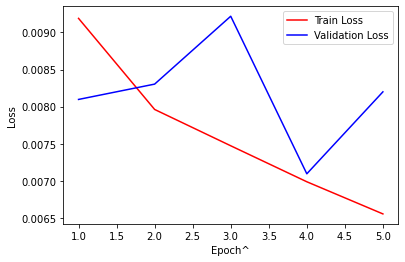

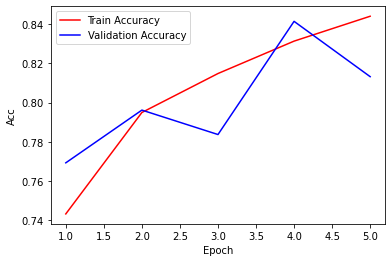

In [11]:
###############################
###        PERFORMANCE      ###
###############################

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, losses, 'r', epoch, val_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch^'), plt.ylabel('Loss')

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')

#print("Train accuracy:", train_acc, sep = "\n")
#print("Validation accuracy:", valid_acc, sep = "\n")

from sklearn.metrics import matthews_corrcoef
print("MCC Train:", matthews_corrcoef(train_targs, train_preds))
print("MCC Test:", matthews_corrcoef(val_targs, val_preds))

print("Confusion matrix train:", confusion_matrix(train_targs, train_preds), sep = "\n")
print("Confusion matrix test:", confusion_matrix(val_targs, val_preds), sep = "\n")

In [12]:
def plot_roc(targets, predictions):
    # ROC
    fpr, tpr, threshold = metrics.roc_curve(targets, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # plot ROC
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()

Text(0.5, 1.0, 'Validation AUC')

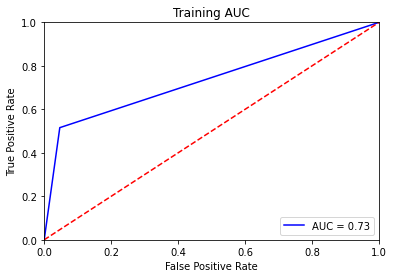

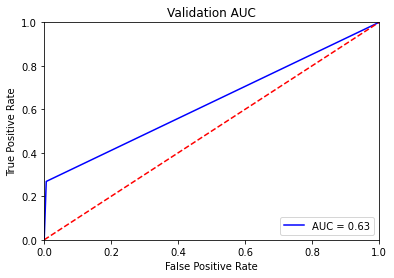

In [13]:
plot_roc(train_targs, train_preds)
plt.title("Training AUC")
plot_roc(val_targs, val_preds)
plt.title("Validation AUC")

# Helpful scripts

# Show dataset as copied dataframes with named features
The dataset is a 3D numpy array, of dimensions n_complexes x features x positions. This makes viewing the features for individual complexes or samples challenging. Below is a function which copies the entire dataset, and converts it into a list of DataFrames with named indices and columns, in order to make understanding the data easier.

NB: This list of dataframes are only copies, and will not be passable into the neural network architecture.

In [27]:
pd.read_csv("data/example.csv")

,A,C,D,E,F,G,H,I,K,L,...,global_tcr_fa_rep,global_tcr_fa_sol,global_tcr_p_aa_pp,global_pmhc_total_score,global_pmhc_fa_atr,global_pmhc_fa_dun,global_pmhc_fa_elec,global_pmhc_fa_rep,global_pmhc_fa_sol,global_pmhc_p_aa_pp
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000


In [28]:
def copy_as_dataframes(dataset_X):
    """
    Returns list of DataFrames with named features from dataset_X,
    using example CSV file
    """
    df_raw = pd.read_csv("data/example.csv")
    return [pd.DataFrame(arr, columns = df_raw.columns) for arr in dataset_X]

named_dataframes = copy_as_dataframes(X_train)
print("Showing first complex as dataframe. Columns are positions and indices are calculated features")
named_dataframes[0]

Showing first complex as dataframe. Columns are positions and indices are calculated features


,A,C,D,E,F,G,H,I,K,L,...,global_tcr_fa_rep,global_tcr_fa_sol,global_tcr_p_aa_pp,global_pmhc_total_score,global_pmhc_fa_atr,global_pmhc_fa_dun,global_pmhc_fa_elec,global_pmhc_fa_rep,global_pmhc_fa_sol,global_pmhc_p_aa_pp
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000


# View complex MHC, peptide and TCR alpha/beta sequences
You may want to view the one-hot encoded sequences as sequences in single-letter amino-acid format. The below function will return the TCR, peptide and MHC sequences for the dataset as 3 lists.

In [29]:
def oneHot(residue):
    """
    Converts string sequence to one-hot encoding
    Example usage:
    seq = "GSHSMRY"
    oneHot(seq)
    """
    
    mapping = dict(zip("ACDEFGHIKLMNPQRSTVWY", range(20)))
    if residue in "ACDEFGHIKLMNPQRSTVWY":
        return np.eye(20)[mapping[residue]]
    else:
        return np.zeros(20)
def reverseOneHot(encoding):
    """
    Converts one-hot encoded array back to string sequence
    """
    mapping = dict(zip(range(20),"ACDEFGHIKLMNPQRSTVWY"))
    seq=''
    for i in range(len(encoding)):
        if np.max(encoding[i])>0:
            seq+=mapping[np.argmax(encoding[i])]
    return seq

def extract_sequences(dataset_X):
    """
    Return DataFrame with MHC, peptide and TCR a/b sequences from
    one-hot encoded complex sequences in dataset X
    """
    mhc_sequences = [reverseOneHot(arr[0:179,0:20]) for arr in dataset_X]
    pep_sequences = [reverseOneHot(arr[179:190,0:20]) for arr in dataset_X]
    tcr_sequences = [reverseOneHot(arr[192:,0:20]) for arr in dataset_X]
    df_sequences = pd.DataFrame({"MHC":mhc_sequences, "peptide":pep_sequences,
                                 "tcr":tcr_sequences})
    return df_sequences

In [30]:
complex_sequences = extract_sequences(X_val)
print("Showing MHC, peptide and TCR alpha/beta sequences for each complex")
complex_sequences

Showing MHC, peptide and TCR alpha/beta sequences for each complex


,MHC,peptide,tcr
0,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
1,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
2,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,QQVKQNSPSLSVQEGRISILNCDYTNSMFDYFLWYKKYPAEGPTFL...
3,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
4,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
...,...,...,...
1521,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,FLYALALLL,QSPQSMFIQEGEDVSMNCTSSSIFNTWLWYKQEPGEGPVLLIALYK...
1522,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,LLFGYPVYV,PQALSIQEGENATMNCSYKTSINNLQWYRQNSGRGLVHLILIRSNE...
1523,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GLCTLVAML,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
1524,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,FLYALALLL,QQVKQNSPSLSVQEGRISILNCDYTNSMFDYFLWYKKYPAEGPTFL...
